<a href="https://colab.research.google.com/github/deethereal/Road_Segmentation/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True )

Mounted at /content/gdrive


In [14]:
import tensorflow as tf
import os
import numpy as np
from skimage.io import imread,imshow
from skimage.transform import resize
import  matplotlib.pyplot as plt
from tqdm import tqdm
import  random


seed= 666
np.random.seed=seed



IMG_WIGTH = 256
IMG_HIGHT = 256
IMG_CHANNELS = 3


TRAINING_PATH ="/content/gdrive/MyDrive/Road_Segmentation/train1/"
TEST_PATH = "/content/gdrive/MyDrive/Road_Segmentation/test/"

train_ids= []
test_ids= []

for path, train_ids, folders in os.walk(TRAINING_PATH):
    train_ids = sorted(train_ids)
    break
for path, test_ids, folders in os.walk(TEST_PATH):
    test_ids = sorted(test_ids)
    break
##print(test_ids)

X_TRAIN = np.zeros((len(train_ids), IMG_HIGHT, IMG_WIGTH, IMG_CHANNELS), dtype=np.uint8)
Y_TRAIN = np.zeros((len(train_ids), IMG_HIGHT, IMG_WIGTH, 1,), dtype=np.bool)

### подгоняем размеры тренировочного изображения и маски

for n, id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=TRAINING_PATH + id_
    img=imread(path+'/images/'+ id_+'.png')[:,:,:IMG_CHANNELS]
    img=resize(img,(IMG_HIGHT,IMG_WIGTH),mode='constant',preserve_range=True)
    X_TRAIN[n]=img  ##заполням пустые X_TRAIN значениями из img
    ##mask = np.zeros((IMG_HIGHT, IMG_WIGTH,1),dtype=np.bool)
    ##for mask_file in next(os.walk(path+'/masks/'))[2]:
    mask_ = imread(path+ '/masks/'+id_+'.png')
    mask_ = np.expand_dims(resize(mask_, (IMG_HIGHT,IMG_WIGTH), mode='constant',preserve_range=True),axis=-1)
        ##mask = np.maximum(mask,mask_)
    Y_TRAIN[n] = mask_  ##заполням пустые Y_TRAIN значениями из img

####Тестовые изображения

X_tests = np.zeros((len(test_ids),IMG_HIGHT,IMG_WIGTH,IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path+'/images/'+id_+'.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0],img.shape[1]])
    img = resize(img,(IMG_HIGHT,IMG_WIGTH), mode='constant', preserve_range=True)
    X_tests[n]=img


print("\nStart create model")
print(len(X_TRAIN))

100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


Start create model
777


In [16]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

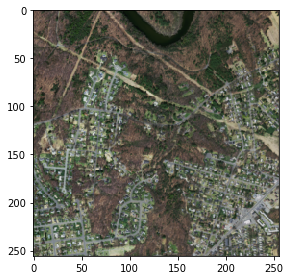

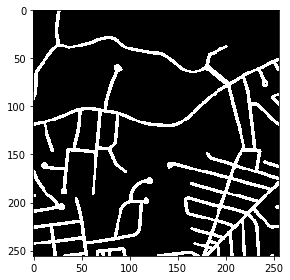

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


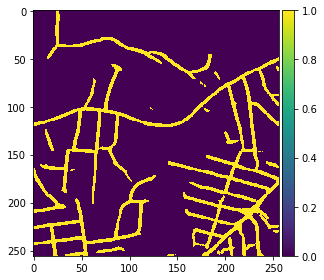

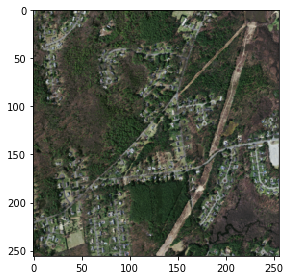

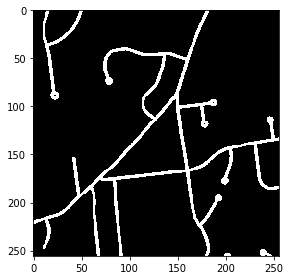

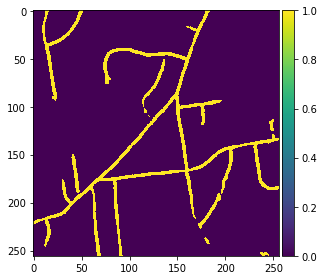

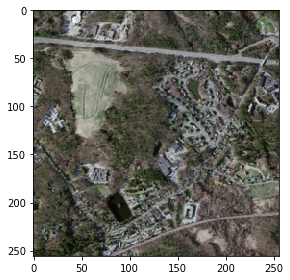

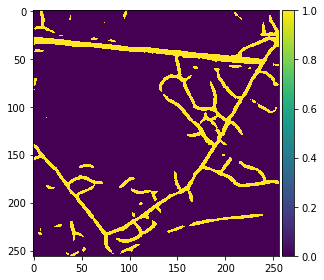

In [17]:
#Построение модели
inputs = tf.keras.layers.Input((IMG_WIGTH, IMG_HIGHT, IMG_CHANNELS))

s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)  ##каждый пиксель делим на 255, чтобы сделать float

##Спуск вниз (свёртка)

#### Первый слой
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1= tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)
####

#### Второй слой
c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2= tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)
####

#### Третий слой
c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3= tf.keras.layers.Dropout(0.1)(c3)
c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)
####

#### Четвертый слой
c4=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4= tf.keras.layers.Dropout(0.1)(c4)
c4=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)
####

#### Пятый слой
c5=tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5= tf.keras.layers.Dropout(0.1)(c5)
c5=tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)
####

#### Шестой слой (последний)
c6=tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6= tf.keras.layers.Dropout(0.1)(c6)
c6=tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
"""
p6=tf.keras.layers.MaxPooling2D((2,2))(c6)
####


#### Седьмой слой (последний)
c7_1=tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p6)
c7_1= tf.keras.layers.Dropout(0.1)(c7_1)
c7_1=tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_1)

p7=tf.keras.layers.MaxPooling2D((2,2))(c7)
####

c8=tf.keras.layers.Conv2D(2048, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p7)
c8= tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(2048, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
####

####  Начинаем собирать изображение назад

u_1024=tf.keras.layers.Conv2DTranspose(1024,(2,2),strides=(2,2),padding='same')(c8)
u7_1024=tf.keras.layers.concatenate([u_1024,c7])
c7_1024=tf.keras.layers.Conv2D(1024,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(u7_1024)
c7_1024=tf.keras.layers.Dropout(0.17)(c7_1024)
c7_1024=tf.keras.layers.Conv2D(1024,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(c7_1024)


####  Начинаем собирать изображение назад


######
u7_0=tf.keras.layers.Conv2DTranspose(512,(2,2),strides=(2,2),padding='same')(c7_1)
u7_0=tf.keras.layers.concatenate([u7_0,c6])
c7_0=tf.keras.layers.Conv2D(512,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(u7_0)
c7_0=tf.keras.layers.Dropout(0.17)(c7_0)
c7_0=tf.keras.layers.Conv2D(512,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(c7_0)
######
"""
####Пятый слой
u7=tf.keras.layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c5])
c7=tf.keras.layers.Conv2D(256,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(u7)
c7=tf.keras.layers.Dropout(0.17)(c7)
c7=tf.keras.layers.Conv2D(256,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(c7)
####

####Четвертый слой
u8=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c7)
u8=tf.keras.layers.concatenate([u8,c4])
c8=tf.keras.layers.Conv2D(128,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(u8)
c8=tf.keras.layers.Dropout(0.17)(c8)
c8=tf.keras.layers.Conv2D(128,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(c8)
####

####Третий слой
u9=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c3])
c9=tf.keras.layers.Conv2D(64,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(u9)
c9=tf.keras.layers.Dropout(0.17)(c9)
c9=tf.keras.layers.Conv2D(64,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(c9)
####

####Второй слой
u10=tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2),padding='same')(c9)
u10=tf.keras.layers.concatenate([u10,c2])
c10=tf.keras.layers.Conv2D(32,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(u10)
c10=tf.keras.layers.Dropout(0.17)(c10)
c10=tf.keras.layers.Conv2D(32,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(c10)
####

####Первый слой
u11=tf.keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), padding='same')(c10)
u11=tf.keras.layers.concatenate([u11,c1])
c11=tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(u11)
c11=tf.keras.layers.Dropout(0.17)(c11)
c11=tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', kernel_initializer='he_normal',padding='same')(c11)
####



outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c11)


model =tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


######################

##Чекпоинт модели
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_segment.h5', verbose=1, save_best_only=True)
call_backs =[
    tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]


results=model.fit(X_TRAIN,Y_TRAIN,validation_split=0.1, batch_size=19,epochs=200, callbacks=call_backs)

#######################################

id_x=random.randint(0,len(X_TRAIN))

preds_train = model.predict(X_TRAIN[:int(X_TRAIN.shape[0]*.09)], verbose =1 )
preds_val = model.predict(X_TRAIN[int(X_TRAIN.shape[0]*.09):], verbose =1 )
preds_test = model.predict(X_tests, verbose=1)

preds_train_t= (preds_train >0.5).astype(np.uint8)
preds_val_t= (preds_val >0.5).astype(np.uint8)
preds_test_t= (preds_test  >0.5).astype(np.uint8)

#####проверка рандомного образца
ix = random.randint(0,len(preds_train_t))
imshow(X_TRAIN[ix])
plt.show()
imshow(np.squeeze(Y_TRAIN[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = random.randint(0,len(preds_train_t))
imshow(X_TRAIN[ix])
plt.show()
imshow(np.squeeze(Y_TRAIN[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

######проверка рандомного подтверждения

ix = random.randint(0,len(preds_test_t))
imshow(X_tests[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()



And here comes tests:


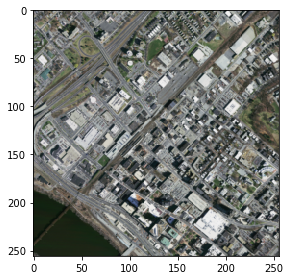

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


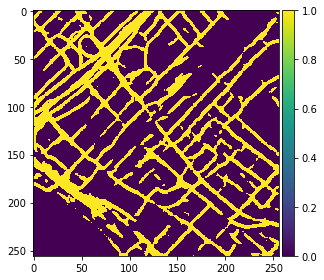

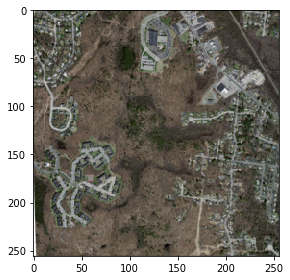

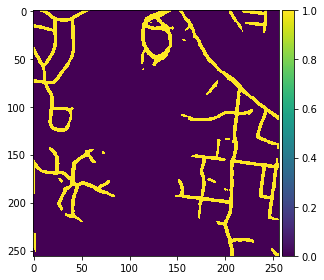

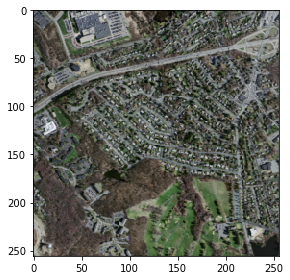

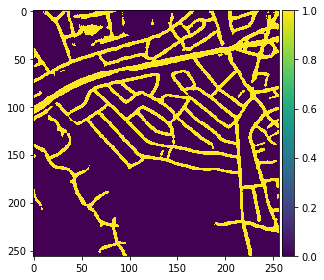

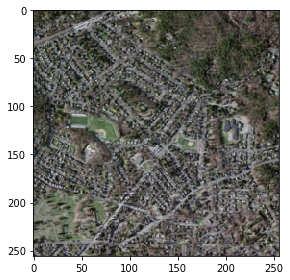

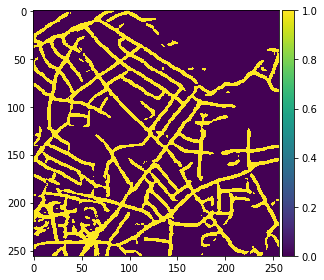

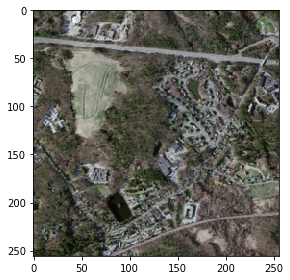

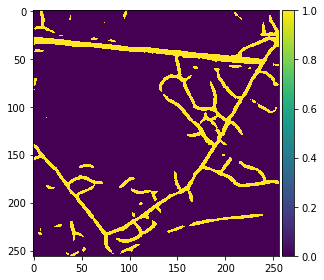

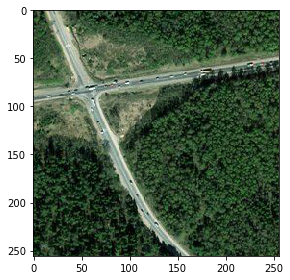

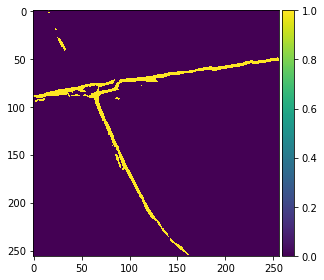

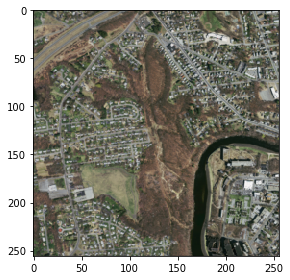

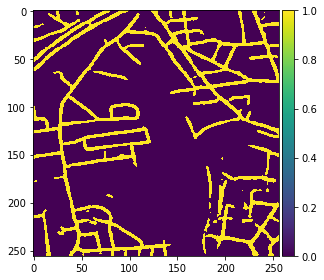

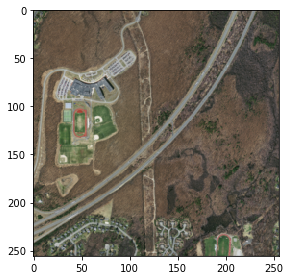

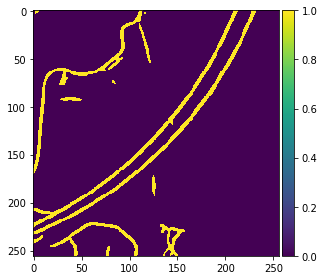

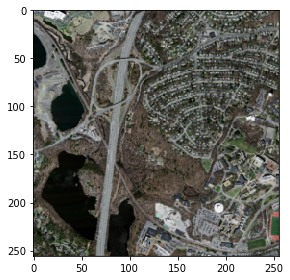

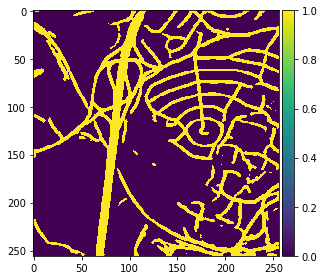

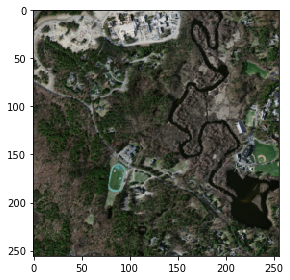

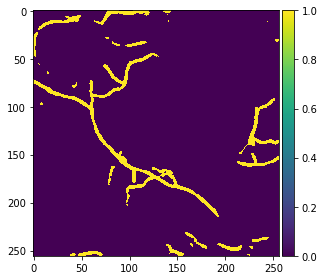

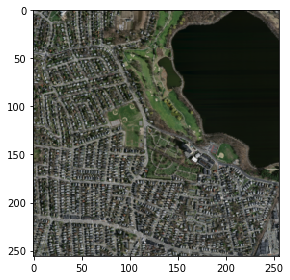

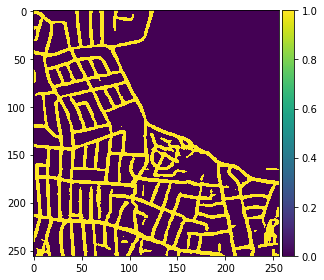

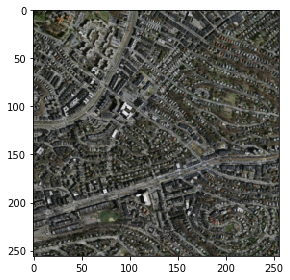

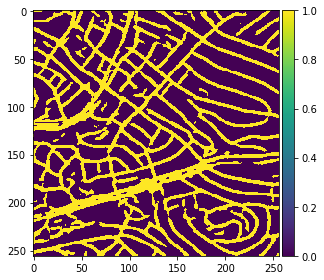

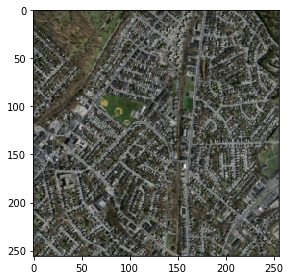

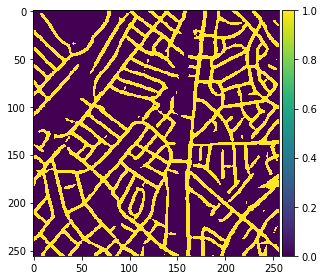

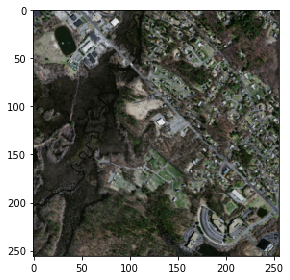

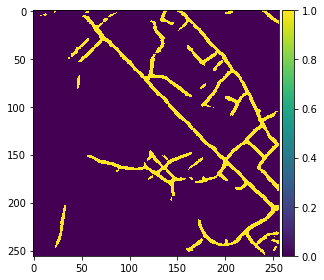

In [18]:
print('\nAnd here comes tests:')

for i in range(len(preds_test_t)):
  imshow(X_tests[i])
  plt.show()
  imshow(np.squeeze(preds_test_t[i]))
  plt.show()